# Analisis Sentimen Rating My Pertamina di Google Play Store

Analisis sentimen adalah metode untuk mengklasifikasikan opini dalam bentuk teks menjadi kategori emosional seperti *positif*, *negatif*, atau *netral*. Pada proyek ini, dilakukan analisis terhadap **ulasan pengguna aplikasi MyPertamina** yang diambil langsung dari Google Play Store melalui proses scraping menggunakan Python.

**Tujuan:**
Proyek ini dibuat sebagai bagian dari submission kelas **Belajar Pengembangan Machine Learning di Dicoding**

**Dataset:**
- **Sumber Data:** Google Play Store (scraping manual dari aplikasi MyPertamina)
- **Jumlah Data Awal:** 20.000 ulasan
- **Setelah Preprocessing:** 19.963 data valid (text_final)
- **Distribusi Kelas:**
  - **Negatif:** ±10.700
  - **Positif:** ±5.000
  - **Netral:** ±4.200


## Import Library dan Data

In [ ]:
!pip install Sastrawi --quiet
!pip install nltk --quiet
!pip install transformers --quiet
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import torch
import re, string, requests
from io import StringIO
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from transformers import BertTokenizer, TFBertForSequenceClassification
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Embedding, LSTM, Bidirectional
from keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

<ipython-input-3-e65c3b4356e0>:26: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/sentimen_pertamina/ulasan_pertamina.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Explore dan Preprosessing Data Scraping

In [ ]:
jumlah_ulasan, jumlah_kolom = df.shape
print("Jumlah ulasan:", jumlah_ulasan)
print("Jumlah kolom:", jumlah_kolom)

Jumlah ulasan: 20000
Jumlah kolom: 1


In [ ]:
df.head()

,Review
0,"UX nya ngga banget. Pas daftar kendaraan, masa..."
1,Aplikasi jadi berat banget operasional nya jal...
2,"Aplikasi sangat buruk, bagian IT tidak bisa Me..."
3,Sudah terdaftar dengan plat nomor lama tp kemu...
4,Baru tadi ngisi pertalite pake mypertamina dan...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20000 non-null  object
dtypes: object(1)
memory usage: 156.4+ KB


In [ ]:
df.isna().sum()

,0
Review,0


In [ ]:
df.duplicated().sum()

np.int64(9)

In [ ]:
df.drop_duplicates(inplace=True)

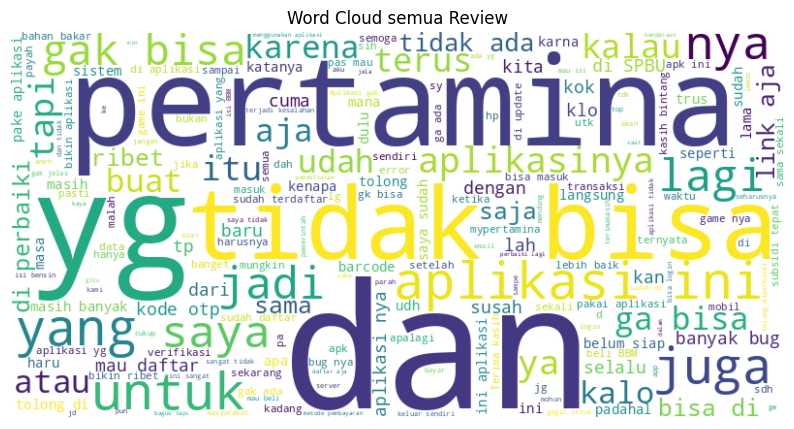

In [ ]:
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Review']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.title('Word Cloud semua Review')
plt.axis('off')
plt.show()

In [ ]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

In [ ]:
def casefoldingText(text):
    return text.lower()

In [ ]:
def fix_slangwords(text):
    slangwords = {
        "abis": "habis", "bgt": "banget", "tp": "tapi", "tdk": "tidak", "gk": "tidak",
        "nggak": "tidak", "ga": "tidak", "yg": "yang", "sy": "saya", "udh": "udah",
        "dr": "dari", "dgn": "dengan", "sm": "sama", "seharusnya": "harus", "gw": "gue",
        "aplikasiny": "aplikasi", "kpn": "kapan", "makasih": "terima kasih", "temen": "teman",
        "trus": "terus", "kalo": "kalau", "klo": "kalau", "pake": "pakai", "sdh": "sudah",
        "sulit": "susah", "baik": "bagus", "lol": "tertawa", "bgt": "banget", "jln": "jalan",
        "smpe": "sampai", "gmn": "gimana", "pdhal": "padahal", "bgt": "banget","gak":"tidak",
        "bagus":"baik", "bug":"error", "bagu":"bagus","gak":"tidak","susah":"ribet",'b aja':"biasa",
        "pas":"sedang","guna":"berguna","lg":"lagi"
    }
    words = text.split()
    return ' '.join([slangwords.get(word.lower(), word) for word in words])


In [ ]:
def tokenizingText(text):
    return re.findall(r'\b\w+\b', text)

In [ ]:
def filteringText(text_tokens):
    listStopwords = set(stopwords.words('indonesian') + stopwords.words('english'))
    listStopwords.update([
        'yg', 'dengan', 'saya', 'ini', 'di', 'untuk', 'saja', 'dan', 'ada', 'juga', 'dah', 'bbm',
        'otp', 'lagi', 'lebih', 'terus', 'tolong', 'masih', 'sama', 'aja', 'aplikasi', 'pertamina',
        'udah', 'seperti', 'apa', 'game', 'gitu', 'sebagai', 'mau', 'buat', 'akan', 'masalah',
        'kok', 'harusnya', 'sudah', 'tp', 'atau', 'login', 'register', 'update', 'akun', 'server',
        'spbu', 'pakai', 'aplikasinya', 'ketika', 'langsung', 'kadang', 'menurut', 'masuk', 'pengguna',
        'buka', 'coba', 'bantu', 'baru', 'selalu', 'banyak', 'kali', 'mudah', 'dari', 'oke',
        'bukan', 'ingin', 'terlihat', 'pada', 'saja', 'masih', 'kita', 'sistem', 'kenapa', 'langsung',
        'yang', 'pengguna', 'gue', 'nya', 'itu', 'ternyata', 'ya', 'yaa', 'kode',
        'jadi', 'daftar', 'pa', 'apk', 'app', 'hp', 'gaa', 'yaa', 'ngaa', 'bayar', 'bisa', 'ga',
        'download', 'bikin', 'banget', 'pake', 'ulang', 'beli','padahal','jg','juga','kan','kok',
        'sih','gimana','gamenya','bagu','sya','g','y','link','moga'
    ])
    return [word for word in text_tokens if word not in listStopwords]

In [ ]:
def toSentence(list_words):
    return ' '.join(list_words)

In [ ]:
stemmer = StemmerFactory().create_stemmer()
def stemmingText(text):
    return stemmer.stem(text)

In [ ]:
df['clean_text'] = df['Review'].apply(cleaningText)
df['clean_text'] = df['clean_text'].apply(casefoldingText)
df['clean_text'] = df['clean_text'].apply(fix_slangwords)
df['tokens'] = df['clean_text'].apply(tokenizingText)
df['tokens'] = df['tokens'].apply(filteringText)
df['text_final'] = df['tokens'].apply(toSentence)
df['text_final'] = df['text_final'].apply(stemmingText)

In [ ]:
lex_pos = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
lex_neg = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

df_pos = pd.read_csv(StringIO(lex_pos.text))
df_neg = pd.read_csv(StringIO(lex_neg.text))

pos_col = df_pos.columns[0]
neg_col = df_neg.columns[0]

positive_words = set(df_pos[pos_col])
negative_words = set(df_neg[neg_col])

def label_sentiment(text):
    tokens = text.split()
    pos_count = sum(1 for word in tokens if word in positive_words)
    neg_count = sum(1 for word in tokens if word in negative_words)
    if pos_count > neg_count:
        return 'positif'
    elif neg_count > pos_count:
        return 'negatif'
    else:
        return 'netral'

df['label'] = df['text_final'].apply(label_sentiment)
df = df[df['label'].isin(['positif', 'negatif', 'netral'])]

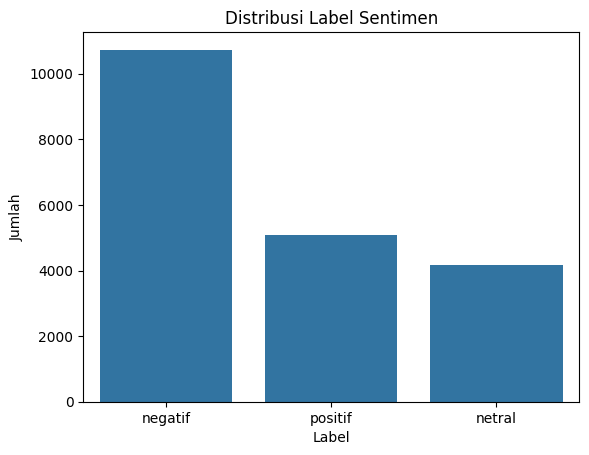

In [ ]:
sns.countplot(data=df, x='label')
plt.title("Distribusi Label Sentimen")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()

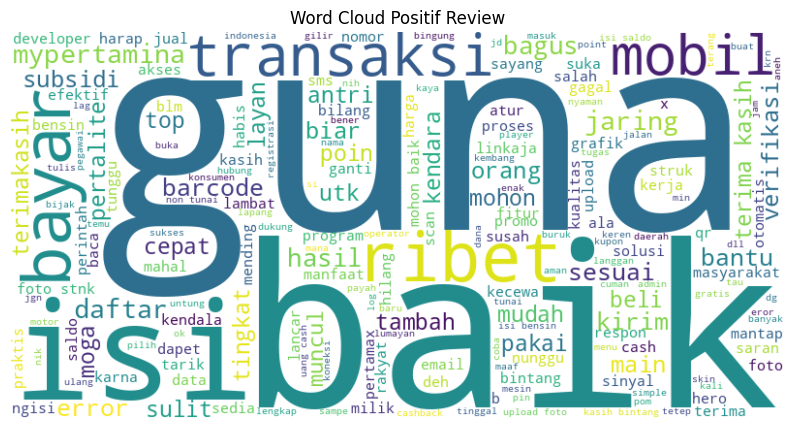

In [ ]:
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df[df['label'] == 'positif']['text_final']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Word Cloud Positif Review')
plt.axis('off')
plt.show()

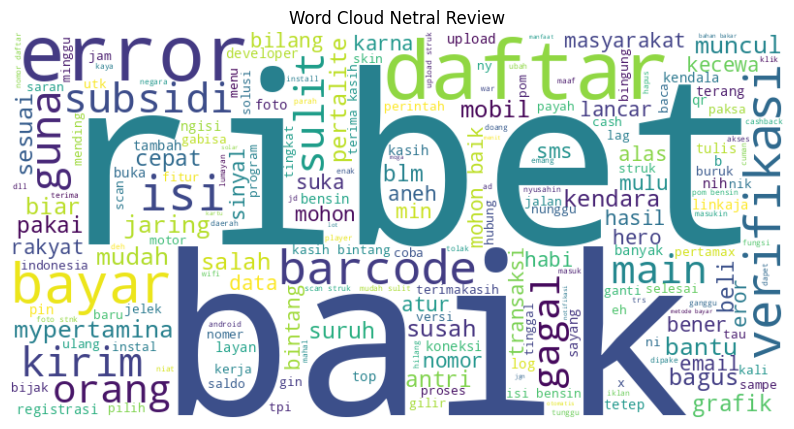

In [ ]:
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df[df['label'] == 'netral']['text_final']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Word Cloud Netral Review')
plt.axis('off')
plt.show()

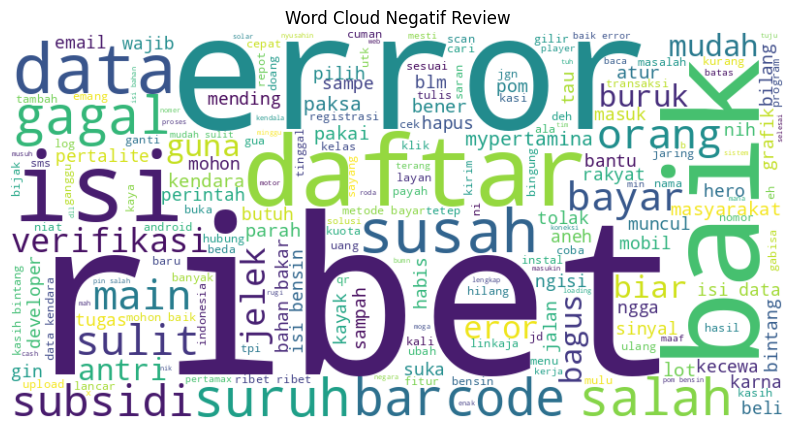

In [ ]:
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df[df['label'] == 'negatif']['text_final']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud Negatif Review')
plt.axis('off')
plt.show()

In [ ]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

In [ ]:
df=df.dropna(subset=['text_final'])

In [ ]:
df['text_final']=df['text_final'].astype(str)

In [ ]:
df.head()

,Review,text_final,label,label_encoded
0,"UX nya ngga banget. Pas daftar kendaraan, masa...",ux ngga kendara ngga sengaja pencet btn back n...,negatif,0
1,Aplikasi jadi berat banget operasional nya jal...,berat operasional jalan lot subsidi ribet muda...,negatif,0
2,"Aplikasi sangat buruk, bagian IT tidak bisa Me...",buruk tangan daftar sulit daftar kendara ulang...,negatif,0
3,Sudah terdaftar dengan plat nomor lama tp kemu...,daftar plat nomor ganti plat karna nomor plat ...,negatif,0
4,Baru tadi ngisi pertalite pake mypertamina dan...,ngisi pertalite mypertamina transaksi scane ga...,negatif,0


In [ ]:
df_preprocessed =  df[['Review', 'text_final', 'label', 'label_encoded']]
file_path = 'ulasan_label_12.csv'
df_preprocessed.to_csv(file_path, index=False)

In [ ]:
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

## Skema Pelatihan

### Deep Learning ANN Algoritma 80 20 TF-IDF (KERAS TUNER)

In [ ]:
y = df['label_encoded']

In [ ]:
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 1))
X_tfidf = vectorizer.fit_transform(df['text_final'])
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
X_train_dl = X_train.toarray()
X_test_dl = X_test.toarray()

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_dl.shape[1],)))
    model.add(Dense(hp.Int('units1', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(Dense(hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('lr', values=[1e-3, 3e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='pertamina_segmentasi'
)

tuner.search(X_train_dl, y_train,
             validation_split=0.2,
             epochs=100,
             batch_size=32,
             class_weight=class_weights,
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)],
             verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Skema 1 Deep Learning + TF-IDF (Tuning)")
print(best_hp.values)

Trial 20 Complete [00h 00m 30s]
val_accuracy: 0.8837136626243591

Best val_accuracy So Far: 0.9040325284004211
Total elapsed time: 00h 11m 21s
Skema 1 Deep Learning + TF-IDF (Tuning)
{'units1': 64, 'dropout1': 0.4, 'units2': 32, 'dropout2': 0.2, 'lr': 0.0003}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
train_acc = best_model.evaluate(X_train_dl, y_train, verbose=0)[1]
test_acc = best_model.evaluate(X_test_dl, y_test, verbose=0)[1]
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Train Accuracy: 0.974612295627594
Test Accuracy: 0.8909727334976196


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2147
           1       0.71      0.84      0.77       836
           2       0.94      0.85      0.89      1016

    accuracy                           0.89      3999
   macro avg       0.87      0.87      0.87      3999
weighted avg       0.90      0.89      0.89      3999



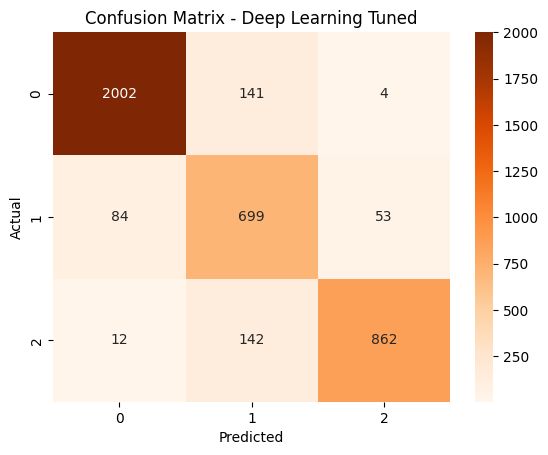

In [ ]:
pred_dl = np.argmax(best_model.predict(X_test_dl), axis=1)
print(classification_report(y_test, pred_dl))
sns.heatmap(confusion_matrix(y_test, pred_dl), annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Deep Learning Tuned')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

In [ ]:
best_model.save('dl_scema1.h5')

In [ ]:
best_model.save('dl_scema1.keras')

### SVM Algoritma 70 30 TF-IDF

In [ ]:
vectorizer_svm = TfidfVectorizer(max_features=10000, ngram_range=(1, 1))
X_svm = vectorizer_svm.fit_transform(df['text_final'])
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y, stratify=y, test_size=0.3, random_state=42)

In [ ]:
svm_model = SVC(C=10, kernel='linear', class_weight='balanced')
svm_model.fit(X_train_svm, y_train_svm)

SVC(C=10, class_weight='balanced', kernel='linear')

In [ ]:
train_acc_svm = svm_model.score(X_train_svm, y_train_svm)
test_acc_svm = svm_model.score(X_test_svm, y_test_svm)
print("Train Accuracy (SVM):", train_acc_svm)
print("Test Accuracy (SVM):", test_acc_svm)

Train Accuracy (SVM): 0.9975702136782677
Test Accuracy (SVM): 0.8829609869956653


              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3220
           1       0.72      0.78      0.75      1253
           2       0.91      0.87      0.89      1525

    accuracy                           0.88      5998
   macro avg       0.86      0.86      0.86      5998
weighted avg       0.89      0.88      0.88      5998



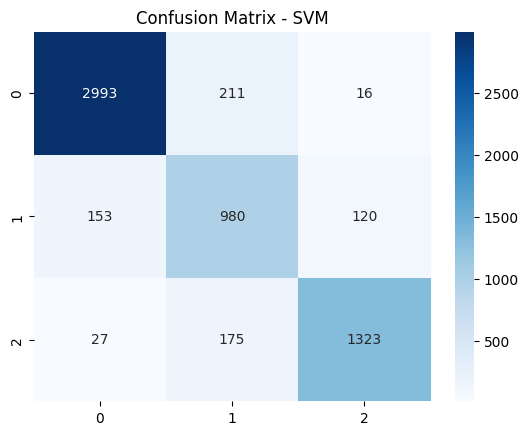

In [ ]:
pred_svm = svm_model.predict(X_test_svm)
print(classification_report(y_test_svm, pred_svm))
sns.heatmap(confusion_matrix(y_test_svm, pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.show()

In [ ]:
joblib.dump(svm_model, 'svm_model_tfidf.pkl')
joblib.dump(vectorizer_svm, 'tfidf_vectorizer_svm.pkl')

['tfidf_vectorizer_svm.pkl']

### Bidirectional LSTM Algoritma 90 10 Tokenization & Embedding (KERAS TUNER)

Trial 30 Complete [00h 01m 35s]
val_accuracy: 0.9162492752075195

Best val_accuracy So Far: 0.9173622727394104
Total elapsed time: 00h 47m 36s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



📊 Skema LSTM Tuned
Best Hyperparameters: {'embed_dim': 100, 'lstm_units': 64, 'dropout1': 0.2, 'dense_units': 64, 'dropout2': 0.2, 'lr': 0.0003}
Train Accuracy: 0.9783492088317871
Test Accuracy: 0.9213820695877075
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1074
           1       0.77      0.90      0.83       415
           2       0.96      0.89      0.93       508

    accuracy                           0.92      1997
   macro avg       0.90      0.91      0.90      1997
weighted avg       0.93      0.92      0.92      1997



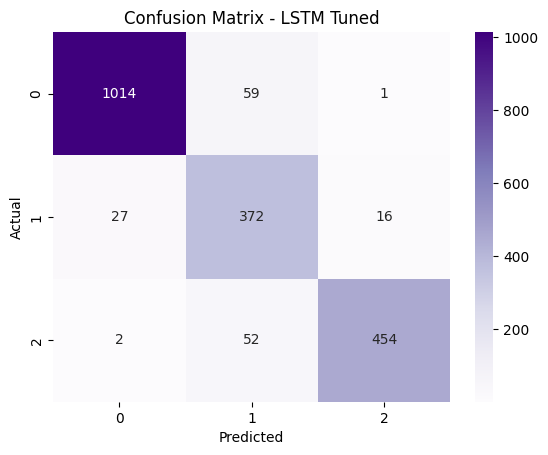

In [ ]:
max_words = 10000
max_len = 100
tokenizer_lstm = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer_lstm.fit_on_texts(df['text_final'])
X_seq = tokenizer_lstm.texts_to_sequences(df['text_final'])
X_pad = pad_sequences(X_seq, maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, stratify=y, test_size=0.1, random_state=42)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

def build_lstm_model(hp):
    model = Sequential()
    model.add(Input(shape=(max_len,)))
    model.add(Embedding(input_dim=max_words, output_dim=hp.Choice('embed_dim', [100, 150, 200])))
    model.add(Bidirectional(LSTM(hp.Choice('lstm_units', [64, 128]), return_sequences=False)))
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(Dense(hp.Choice('dense_units', [32, 64, 128]), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.1)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 3e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='lstm_dir',
    project_name='lstm_1'
)

tuner.search(X_train, y_train,
             validation_split=0.2,
             epochs=100,
             batch_size=32,
             class_weight=class_weights,
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)],
             verbose=1)

best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

print("\n📊 Skema LSTM Tuned")
print("Best Hyperparameters:", best_hp.values)

train_acc = best_model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = best_model.evaluate(X_test, y_test, verbose=0)[1]
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

pred_lstm = np.argmax(best_model.predict(X_test), axis=1)
print(classification_report(y_test, pred_lstm))
sns.heatmap(confusion_matrix(y_test, pred_lstm), annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix - LSTM Tuned')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
best_model.save("model_lstm_tuned.h5")
best_model.save("model_lstm_tuned.keras")

In [ ]:
with open("tokenizer_lstm.pkl", "wb") as f:
    joblib.dump(tokenizer_lstm, f)

In [ ]:
params = {"max_words": max_words, "max_len": max_len}
with open("lstm_params.pkl", "wb") as f:
    joblib.dump(params, f)

## Results Final

### Skema 1: ANN + TF-IDF (80 20)
- **Ekstraksi Fitur:** TF-IDF (2000 fitur, ngram (1,1) )
- **Split Data:** 80:20
- **Model:** Sequential (2 Hidden Layers)
- **Tuning:** Keras Tuner
- **Akurasi:**
  - Train: ±97%
  - Test: ±89%

### Skema 2: SVM + TF-IDF (70 30)
- **Ekstraksi Fitur:** TF-IDF (10000 fitur)
- **Split Data:** 70:30
- **Model:** Support Vector Machine (Linear)
- **Akurasi:**
  - Train: ±99%
  - Test: ±88%

### Skema 3: LSTM + Embedding (90 10)
- **Ekstraksi Fitur:** Tokenizer + Embedding Layer
- **Split Data:** 90:10
- **Model:** Bidirectional LSTM
- **Tuning:** Keras Tuner (30 trials)
- **Best Hyperparameter:** 100-dim embed, LSTM 64, Dropout 0.2, LR 3e-4
- **Akurasi:**
  - Train: 97.8%
  - Test: **92.1%**
- Sangat Optimal (tertinggi)

### Kesimpulan:
- Dataset valid hasil scraping mandiri (19.963 sampel dari 20.000+ data mentah)
- Tiga skema pelatihan model digunakan, masing-masing dengan variasi fitur, algoritma, dan split data
- Seluruh skema menghasilkan akurasi **test set ≥ 85%**, dan salah satu skema (LSTM) memiliki **akurasi training dan testing ≥ 92%**
- Struktur label tiga kelas: negatif, netral, positif




In [ ]:
!pip freeze

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.3.31.0.36.18
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.2.1
blosc2==3.2.1
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
